In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer
from torch.utils.data import DataLoader, TensorDataset
import scipy.stats as stats
from torchsummary import summary
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.base import BaseEstimator
from torchmetrics import MeanSquaredError, R2Score

## Load Data

In [2]:
df = pd.read_csv('./leap-atmospheric-physics-ai-climsim/train.csv', sep=',', nrows=10000)

In [3]:
# double check column index num to split input and output data
print("Training data: ", df.columns.get_loc('ptend_t_0'))

Training data:  557


In [4]:
# 556 input columns, double check that is correct
# last input variable should be pbuf_N20_59
df.iloc[:, 1:557].columns

Index(['state_t_0', 'state_t_1', 'state_t_2', 'state_t_3', 'state_t_4',
       'state_t_5', 'state_t_6', 'state_t_7', 'state_t_8', 'state_t_9',
       ...
       'pbuf_N2O_50', 'pbuf_N2O_51', 'pbuf_N2O_52', 'pbuf_N2O_53',
       'pbuf_N2O_54', 'pbuf_N2O_55', 'pbuf_N2O_56', 'pbuf_N2O_57',
       'pbuf_N2O_58', 'pbuf_N2O_59'],
      dtype='object', length=556)

In [5]:
df.dtypes.value_counts()

float64    924
object       1
Name: count, dtype: int64

## Feature Selection

In [6]:
input_df = df.iloc[:, 1:557]
output_df = df.iloc[:, 557:]

In [7]:
# check which columns have very small variance
low_variance_cols = np.where(np.std(input_df, axis=0) < 1e-6)[0]
print(len(low_variance_cols))
print(low_variance_cols)

238
[ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 376 377 378 379 380
 381 382 388 389 394 395 396 397 398 399 400 401 402 403 404 405 406 407
 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425
 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443
 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461
 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497
 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515
 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533
 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551
 552 553 554 555]


In [8]:
# check if any of small variance features have correlation with outputs
correlated_cols = []

for col_index in low_variance_cols:
    correlation_check = 0
    for output_col in output_df.columns:
        input_col = input_df.columns[col_index]
        corr_coef = input_df[input_col].corr(output_df[output_col])
        if -0.1 <= corr_coef <= 0.1 or np.isnan(corr_coef):
            continue
        else:
            correlation_check = 1
            break
    if correlation_check == 1:
        correlated_cols.append(col_index)

print(correlated_cols)
print(len(correlated_cols))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 376, 377, 378, 379, 380, 381, 382, 388, 389, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522]
171


In [9]:
# create list of features with no correlation
set1 = set(low_variance_cols)
set2 = set(correlated_cols)

no_corr_or_var = list(set1 - set2)
print(len(no_corr_or_var))
print(no_corr_or_var)

67
[135, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495]


In [10]:
# drop low variance with no correlation columns
input_df_clean = input_df.drop(input_df.columns[no_corr_or_var], axis=1)
input_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 489 entries, state_t_0 to pbuf_N2O_26
dtypes: float64(489)
memory usage: 37.3 MB


In [11]:
# check normal distribution, use MinMaxScaler if most features are not normally distributed
p_threshold = 0.05
not_norm_num = 0
for col in input_df_clean.iloc[:, 1:].columns:
    stat, p = stats.normaltest(df[col])
    if p <= p_threshold:
        not_norm_num += 1

print(f'Number of input features not normally distributed = {not_norm_num} out of {len(input_df_clean.columns)}')

Number of input features not normally distributed = 477 out of 489


## Setting up Mac GPU

In [12]:
# Swap to MacOS GPU via MPS
if torch.backends.mps.is_available():
   device = torch.device("mps")
   x = torch.ones(1, device=device)
   print (x)
else:
   print ("MPS device not found.")

tensor([1.], device='mps:0')


## Data Sets

In [13]:
# split into train, validation, and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(input_df_clean, output_df, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# convert to numpy arrays
X_train_numpy = X_train.to_numpy()
X_val_numpy = X_val.to_numpy()
X_test_numpy = X_test.to_numpy()
y_train_numpy = y_train.to_numpy()
y_val_numpy = y_val.to_numpy()
y_test_numpy = y_test.to_numpy()

# MinMaxScaler due to normal distribution test failing earlier
scaler = MinMaxScaler()
X_train_numpy = scaler.fit_transform(X_train_numpy)
X_val_numpy = scaler.transform(X_val_numpy)
X_test_numpy = scaler.transform(X_test_numpy)

# convert to tensors
X_train_tensor = torch.tensor(X_train_numpy, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_numpy, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_numpy, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_numpy, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_numpy, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_numpy, dtype=torch.float32)

## Hyperparameters

In [14]:
input_size = X_train_tensor.shape[1]
hidden_size = 694
output_size = y_train_tensor.shape[1]
batch_size = 256
num_epochs = 80
learning_rate = 0.01
regularization_param = 0.0001
momentum_param = 0.9
dropout_p = 0.1

scheduler_factor = 0.1
scheduler_patience = 5

## Defining the model

In [15]:
# hidden layer function
def hidden_layer(hidden_size=hidden_size, dropout_p=dropout_p):
    return nn.Sequential(
        nn.Linear(hidden_size, hidden_size),
        nn.BatchNorm1d(hidden_size),
        nn.LeakyReLU(),
        nn.Dropout(dropout_p)
    )

# create model variable and input layer
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.LeakyReLU(),
    nn.Dropout(dropout_p),
)
# add hidden layers
for _ in range(3):
    model.add_module(str(len(model)), hidden_layer(hidden_size, dropout_p))
# add output layer
model.add_module(str(len(model)), nn.Linear(hidden_size, output_size))

# evaluation metrics
metric = R2Score(num_outputs=output_size).to(device=device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization_param)

# scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=scheduler_factor, patience=scheduler_patience)

# data loaders
train_dl = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size, shuffle=True)
val_dl = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size, shuffle=False)
test_dl = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size, shuffle=False)

## Running the model

In [16]:
train_losses = []
val_losses = []
r2_scores = []
patience_count = 0
best_loss = float('inf')
best_model = None
total_epochs = 0

model.to(device)

for epoch in range(num_epochs):
    total_epochs += 1

    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_dl:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        # Forward pass
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    all_outputs = torch.tensor([], dtype=torch.float32, device=device)
    all_targets = torch.tensor([], dtype=torch.float32, device=device)
    with torch.no_grad():
        for x_val, y_val in val_dl:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            val_loss += criterion(outputs, y_val).item()
            all_outputs = torch.cat((all_outputs, outputs), dim=0)
            all_targets = torch.cat((all_targets, y_val), dim=0)

    val_loss /= len(val_dl)
    val_losses.append(val_loss)

    # r2 score
    for i in range(output_size):
        metric.update(all_outputs[:, i], all_targets[:, i])
    r2_score = metric.compute()
    r2_scores.append(r2_score.item())
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, R2 Score: {r2_score:.4f}')

    # run scheduler
    scheduler.step(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        patience_count = 0
        best_model = model.state_dict()
        print('Validation loss improved. Saving model...\n')
    else:
        patience_count += 1
        if patience_count == scheduler_patience * 3:
            print('Training stopped. Patience count:', patience_count)
            break
        elif patience_count % scheduler_patience == 0:
            print('Reducing learning rate. Patience count:', patience_count)
        else:
            print("No improvement. Patience count:", patience_count)



Epoch [1/80], Train Loss: 442.9306, Val Loss: 283.1859, R2 Score: 0.5743
Validation loss improved. Saving model...

Epoch [2/80], Train Loss: 185.5951, Val Loss: 156.0741, R2 Score: 0.6700
Validation loss improved. Saving model...

Epoch [3/80], Train Loss: 57.8141, Val Loss: 29.6984, R2 Score: 0.7651
Validation loss improved. Saving model...

Epoch [4/80], Train Loss: 20.1724, Val Loss: 40.7653, R2 Score: 0.8084
No improvement. Patience count: 1
Epoch [5/80], Train Loss: 17.3571, Val Loss: 34.6544, R2 Score: 0.8363
No improvement. Patience count: 2
Epoch [6/80], Train Loss: 14.3086, Val Loss: 41.7330, R2 Score: 0.8531
No improvement. Patience count: 3
Epoch [7/80], Train Loss: 11.5479, Val Loss: 16.2205, R2 Score: 0.8706
Validation loss improved. Saving model...

Epoch [8/80], Train Loss: 11.4860, Val Loss: 20.7994, R2 Score: 0.8829
No improvement. Patience count: 1
Epoch [9/80], Train Loss: 11.2864, Val Loss: 14.2635, R2 Score: 0.8935
Validation loss improved. Saving model...

Epoch 

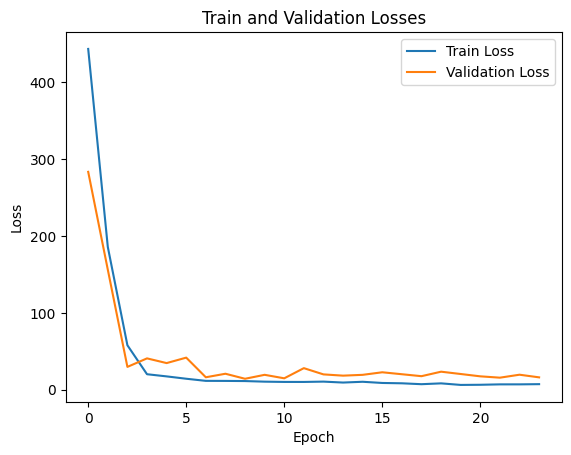

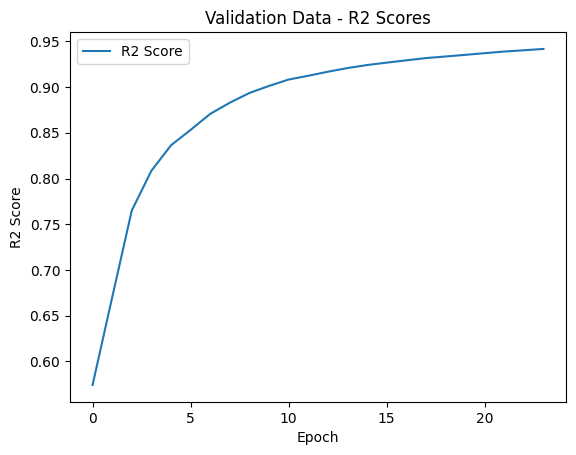

In [17]:
# Plotting train and validation losses
plt.plot(range(total_epochs), train_losses, label='Train Loss')
plt.plot(range(total_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.show()

# Plotting r2 scores
plt.plot(range(total_epochs), r2_scores, label='R2 Score')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.title('Validation Data - R2 Scores')
plt.legend()
plt.show()

## Testing the model

In [18]:
test_model = model
test_model.load_state_dict(best_model)

test_loss = 0.0
test_outputs = torch.tensor([], dtype=torch.float32, device=device)
test_targets = torch.tensor([], dtype=torch.float32, device=device)

test_model.eval()
with torch.no_grad():
    for x_test, y_test in test_dl:
        x_test, y_test = x_test.to(device), y_test.to(device)
        outputs = test_model(x_test)
        test_loss += criterion(outputs, y_test).item()
        test_outputs = torch.cat((test_outputs, outputs), dim=0)
        test_targets = torch.cat((test_targets, y_test), dim=0)

print("Test Data Set Results")
# loss
test_loss /= len(test_dl)
print(f"Test Loss: {test_loss:.4f}")

# r2 score
for i in range(output_size):
    metric.update(test_outputs[:, i], test_targets[:, i])
r2_score = metric.compute()

print(f"R2: {r2_score.item():.4f}")

Test Data Set Results
Test Loss: 16.5688
R2: 0.9431


## Saving the model

In [ ]:
torch.save(best_model, 'PML_Final_Model.pt')